# Mindset datasets

## Previous ideas and shortcomings
This is related to the work on the correspondence between Mindsets and Gaussian models.

When investigating a bit closer, the similarity between the mindset setting and triplets becomes more obvious. We have discussed, that with certain conditions, the Gaussian model (k clusters with n datapoints each) could be viewed as a specific instance of the Mindset model (k mindsets with n datapoints each that represent a specific way of answering m questions), namely when the standard deviation was vanishingly small compared to the inter-cluster distances. 

Then, the only interesting questions where those that were of the form "b:c?", where b and c are in separate clusters. There, points that belonged to the same cluster as b should answer with 1, points that are in the same cluster as c should answer with 0, and the rest should answer consistently, but randomly (this is given as long as the geometry is not so that the cut between two cluster centers cuts another cluster). This is similar to the mindset example with k clusters, n points and ${k \choose 2}$ questions (total number of useful questions).

We recognized that this example may be a bit shoehorned in. By starting with a gaussian model, we are already putting in assumptions about the shape of our triplets (namely, that they come from a metric space and thus respect certain properties). These might not be the most suitable for the tangles algorithm, and we see SOE-kMeans heavily outperforming our algorithm. SOE-kMeans generates a _euclidean_ space, and then finds clusters using kMeans (which underlies a gaussian assumption).

## New approach
We found that the previous approach was a bit backwards. Why not do it exactly the other way around – start with the mindset example? Assume that we have $k$ mindsets consisting of $n$ people each, and they are asked $m$ questions. Each mindset corresponds to a certain way of answering a question. For now, assume that each person answers fully faithful to their mindset. 

The data that corresponds to the problem setup is an $N = k * n$ times $m$ table, with $k$ unique answer vectors (corresponding to a mindset each). 

### Questions correspond to triplets
First off, we have to think about what triplets essentially are, and why we are interested in them. Triplets are similarity informations of the form (a,b,c), where we know whether
a is closer to b than to c or vice versa. We can equivalently cast the triplet problem in question form, as a triplet being the question "b:c?" together with an answer for a point a.

The similarity that triplets are based on might not be a metric in general, so pinpointing their properties is pretty hard. If we view triplets in the question case, we can formulate what we require from them for clustering, namely that similar points $a1, a2$ give similar answers to the triplets questions (ideally the same, or the same with high probability). 

Assume that no question is degenerate (i.e. everyone answers 1 or 0). Then, we might also think of a question of the form $q_i$ as corresponding to a triplet a:b?, where a is randomly selected person from any mindset that has answered 1 to question $q_i$, and equivalently b is any randomly selected person that has answered 0. For different questions, we might always pick different combinations of people. 

What then results is, that for every person $p$ of mindset $m_j$, they answer the question in an intuitively correct way. 
If a is of mindset $m_j$, they answer with 1 (so they are similar to the person with the same mindset), if b is of mindset $m_j$, they answer with 0. If a and b are neither of mindset $m_j$, the person can answer randomly, but consistently with people of the same mindset.

This in turn allows us to identify every question with exactly one triplet question that contains meaningful similarity information (or equivalently, every answer with one triplet that contains meaningful similarity information). With very high probability, these triplets will however NOT come from a metric space. 

Note that we can still add noise as well. This just relaxes the requirement, that all similar people have to give the same answers, to the requirement, that similar people shall give similar answers (exactly what we required beforehand).

## Experimental validation
As a follow-up, we want to find out whether SOE-kMeans can also handle the triplet data from this highly non-metric space. 

In [1]:
import sys
sys.path.append("..")
from estimators import OrdinalTangles
from tangles.loading import make_mindsets, load_SBM
from tangles.cut_finding import kernighan_lin
from cblearn.embedding import SOE
from questionnaire import Questionnaire
from sklearn.cluster import KMeans
from plotting import AltairPlotter
from sklearn.metrics import normalized_mutual_info_score
from baselines import find_k_silhouette
import altair as alt
alt.renderers.enable('altair_saver', fmts=["html", "svg"])

RendererRegistry.enable('altair_saver')

In [2]:
seed = 4
xs, ys, mindsets = make_mindsets([333, 333, 333], 40, None, 0, seed=seed)
tangles = OrdinalTangles(111, verbose=True)
ypred_tangles = tangles.fit_predict(xs)

q = Questionnaire.from_bipartitions(xs)

kmeans = KMeans(n_clusters=3)
soe = SOE(n_components=2)
embedding = soe.fit_transform(*q.to_bool_array())
ypred_soe_kmeans = kmeans.fit_predict(embedding)

Computing costs of cuts...


100%|██████████| 40/40 [00:00<00:00, 622.23it/s]
/opt/homebrew/Caskroom/mambaforge/base/envs/tangles-thesis/lib/python3.9/site-packages/tangles/utils.py:58: RuntimeWarning: invalid value encountered in true_divide
  return (array - np.min(array)) / np.ptp(array)


	3 leaves before cutting out short paths.
	3 clusters after cutting out short paths.
Computing costs of cuts...


100%|██████████| 40/40 [00:00<00:00, 682.01it/s]

No probabilities given yet. Calculating soft predictions first!


## Evaluation

In [3]:
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"SOE-kMeans NMI: {normalized_mutual_info_score(ys, ypred_soe_kmeans)}")

Tangles NMI: 1.0
SOE-kMeans NMI: 0.5270990263866365


As we can see, Tangles performs a lot better on this super simple scenario already. One can safely increase the noise in the data to almost 0.2, with Tangles still reaching an optimal performance.

Next up, we will see how the embedding looks like.

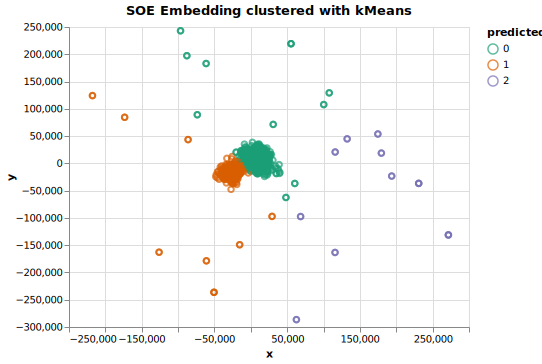

In [4]:
plotter = AltairPlotter()
plotter.assignments(embedding, ypred_soe_kmeans).properties(title="SOE Embedding clustered with kMeans")

We can see that the embedding fails to correctly uphold a lot of the Triplet restrictions
and doesn't produce the three-cluster structure we would expect.
The embedding looks more like it produced one cluster instead of 3, and the corresponding labels assigned by kMeans reflect that. When repeatedly running the experiment with different data values, we also saw different behaviours (3 clusters with seed 1 and acceptable performance, 2-ish clusters with seed 4).

Maybe we were a bit unfair to SOE by only giving it 2 embedding dimensions. We will repeat the task while increasing the embedding dimensions (but also increasing the noise, as it is pretty trivial to correctly cluster noiseless data when the model is flexible enough).

In [5]:
xs, ys, mindsets = make_mindsets([333, 333, 333], 40, None, 0.15, seed=seed)
tangles = OrdinalTangles(111)
ypred_tangles = tangles.fit_predict(xs)

q = Questionnaire.from_bipartitions(xs)

kmeans = KMeans(n_clusters=3)
soe = SOE(n_components=5)
embedding = soe.fit_transform(*q.to_bool_array())
ypred_soe_kmeans = kmeans.fit_predict(embedding)

Tangles NMI: 0.9843931230224583
SOE-kMeans NMI: 0.3916905061436328


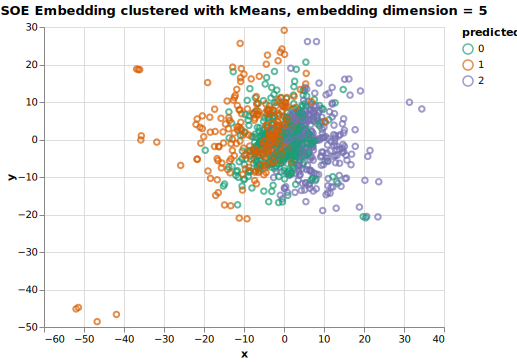

In [6]:
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"SOE-kMeans NMI: {normalized_mutual_info_score(ys, ypred_soe_kmeans)}")

plotter.assignments(embedding[:, :2], ypred_soe_kmeans).properties(title="SOE Embedding clustered with kMeans, embedding dimension = 5")

As we can see, Tangles still retains better performance, but in this case, the embedding is more flexible and can reproduce the cluster structure reasonably well. We do note however that tangles is computationally a lot faster than SOE at better performance.

## Tangles and actual triplets
What is missing from this depiction, is that the problem setup in real triplet experiments is usually different. What we get is a low number of triplets sampled from a huge swath of triplets. In this case, we are providing questionnaires, where questions / columns are completely filled out. We have seen in past experiments that this works reasonably well for triplets as long as the number of questions doesn't dip below a certain threshhold (probably dependent on total number of datapoints/participants). 

The question remains of how to incorporate real triplets into the tangles framework? We saw that only providing a small amount of triplets and filling out the rest randomly results in a very quickly deteriorating performance in tangles (see investigations to noise). 
This approach is akin to just adding a lot of noise on the bipartitions, which the tangles algorithm can only tolerate up to a certain % (this probably has to do with the aligning mechanism).

In the next section, we will highlight these shortcomings by providing only a subset of the triplets and filling the rest with noise.

In [7]:
# We'll stay with the setup from above
seed = 6
xs, ys, mindsets = make_mindsets([333, 333, 333], 40, None, 0, seed=seed)
q = Questionnaire.from_bipartitions(xs)
q_sub = q.subset(5000, seed=seed)

tangles = OrdinalTangles(111, verbose=True)
ypred_tangles = tangles.fit_predict(q_sub.impute("random").values)

kmeans = KMeans(n_clusters=3)
soe = SOE(n_components=2, random_state=seed)
embedding = soe.fit_transform(*q_sub.to_bool_array())
ypred_soe_kmeans= kmeans.fit_predict(embedding)

Computing costs of cuts...


100%|██████████| 30/30 [00:00<00:00, 449.45it/s]


	24 leaves before cutting out short paths.
	23 clusters after cutting out short paths.
Computing costs of cuts...


100%|██████████| 30/30 [00:00<00:00, 574.79it/s]

No probabilities given yet. Calculating soft predictions first!


In [8]:
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"SOE-kMeans NMI: {normalized_mutual_info_score(ys, ypred_soe_kmeans)}")

Tangles NMI: 0.034249091981165394
SOE-kMeans NMI: 0.712486290436858


As we can see, the Tangles algorithm performs very poor, while SOE-kMeans has a still acceptable performance. We can alleviate this issue by using k-NN imputation instead.

In [9]:
ypred_tangles = tangles.fit_predict(q_sub.impute("10-NN").values)
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"SOE-kMeans NMI: {normalized_mutual_info_score(ys, ypred_soe_kmeans)}")

Imputing via knn
Computing costs of cuts...


100%|██████████| 30/30 [00:00<00:00, 634.41it/s]

	3 leaves before cutting out short paths.


	3 clusters after cutting out short paths.
Computing costs of cuts...


100%|██████████| 30/30 [00:00<00:00, 638.85it/s]

No probabilities given yet. Calculating soft predictions first!
Tangles NMI: 0.813574080315432
SOE-kMeans NMI: 0.712486290436858


This causes the tangles algorithm to outperform kMeans again, by a significant margin.
We will see how kMeans performs on the original data directly.

In [10]:
kmeans = KMeans(n_clusters=3)
y_direct_pred = kmeans.fit_predict(q.values)
y_random_subset = kmeans.fit_predict(q_sub.impute("random").values)
y_knn_subset = kmeans.fit_predict(q_sub.impute("10-NN").values)
print(f"Direct kMeans on q: {normalized_mutual_info_score(ys, y_direct_pred)}")
print(f"Direct kMeans on q subset randomly imputed: {normalized_mutual_info_score(ys, y_random_subset)}")
print(f"Direct kMeans on q subset 10-NN imputed: {normalized_mutual_info_score(ys, y_knn_subset)}")

Imputing via knn
Direct kMeans on q: 1.0
Direct kMeans on q subset randomly imputed: 0.06331311854197938
Direct kMeans on q subset 10-NN imputed: 0.8142995345243922


We see that kMeans on the subsets performs very similar to Tangles. 

## Exploring imputed kMeans vs Tangles
The just observed performance of kMeans is a bit strange, as we know it works best on euclidean gaussian data.

It would be interesting to explore more scenarios and see how kMeans holds up to Tangles.

### Questionaire with useless questions added
We have already observed that kMeans is good at filtering useless questions. In a real-life scenario, this might be triplets b:c? where the two object b, c are so close together that any point a will be randomly assigned (think of b,c being two images of identical trees), or objects b, c that have nothing to do with each other and the datapoints (think of kitchen sinks in a questionnaire about trees).

In [11]:
# We'll stay with the setup from above
seed = 6
xs, ys, mindsets = make_mindsets([333, 333, 333], 40, 40, 0.15, seed=seed)
q = Questionnaire.from_bipartitions(xs)

tangles = OrdinalTangles(111, verbose=True)
ypred_tangles = tangles.fit_predict(q.values)
kmeans = KMeans(find_k_silhouette(q.values))
ypred_kmeans_silhouette = kmeans.fit_predict(q.values)

soe = SOE(n_components=3, random_state=seed)
embedding = soe.fit_transform(*q.to_bool_array())
kmeans = KMeans(3)
ypred_soe_kmeans = kmeans.fit_predict(embedding)

Computing costs of cuts...


100%|██████████| 80/80 [00:00<00:00, 587.39it/s]

	5 leaves before cutting out short paths.


	3 clusters after cutting out short paths.
Computing costs of cuts...


100%|██████████| 80/80 [00:00<00:00, 608.05it/s]


No probabilities given yet. Calculating soft predictions first!


In [12]:
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"SOE-kMeans NMI: {normalized_mutual_info_score(ys, ypred_soe_kmeans)}")
print(f"Silhouette kMeans NMI: {normalized_mutual_info_score(ys, ypred_kmeans_silhouette)}")

Tangles NMI: 0.9690842337073245
SOE-kMeans NMI: 0.7649112583430869
Silhouette kMeans NMI: 1.0


As we can see, tangles perform subpar to a direct kMeans clustering, even when we use the silhouette method to find k.

### Questionnaire from graph cuts
Intuition of how to translate questionnaire to bipartitions should be the same as in the mindset case.

In [13]:
seed = 6
A, ys, G = load_SBM(block_sizes=[50, 50, 50, 50], p_in=0.5, p_out=0.1, seed=seed)
cuts = kernighan_lin(A, nb_cuts=20, lb_f=0.1, seed=seed, verbose=0, early_stopping=5)

q = Questionnaire.from_bipartitions(cuts.T)

tangles = OrdinalTangles(25, verbose=True)
ypred_tangles = tangles.fit_predict(q.values)
 
kmeans = KMeans(n_clusters=3)
ypred_kmeans = kmeans.fit_predict(q.values)

soe_low = SOE(n_components=2)
embedding_low = soe.fit_transform(*q.to_bool_array())
ypred_soe_kmeans_low = kmeans.fit_predict(embedding_low)

soe_high = SOE(n_components=5)
embedding_high = soe.fit_transform(*q.to_bool_array())
ypred_soe_kmeans_high = kmeans.fit_predict(embedding_high)

Computing costs of cuts...


100%|██████████| 20/20 [00:00<00:00, 7674.85it/s]


	4 leaves before cutting out short paths.
	4 clusters after cutting out short paths.
Computing costs of cuts...


100%|██████████| 20/20 [00:00<00:00, 7081.98it/s]

No probabilities given yet. Calculating soft predictions first!


In [14]:
print(f"Tangles NMI: {normalized_mutual_info_score(ys, ypred_tangles)}")
print(f"kMeans NMI: {normalized_mutual_info_score(ys, ypred_kmeans)}")
print(f"SOE-kMeans NMI low dim: {normalized_mutual_info_score(ys, ypred_soe_kmeans_low)}")
print(f"SOE-kMeans NMI high dim: {normalized_mutual_info_score(ys, ypred_soe_kmeans_high)}")

Tangles NMI: 0.9284918133637959
kMeans NMI: 0.8352369878190498
SOE-kMeans NMI low dim: 0.6788660719910876
SOE-kMeans NMI high dim: 0.6788660719910876


Here we see an example where Tangles outperform direct kMeans as well as SOE-kMeans. 

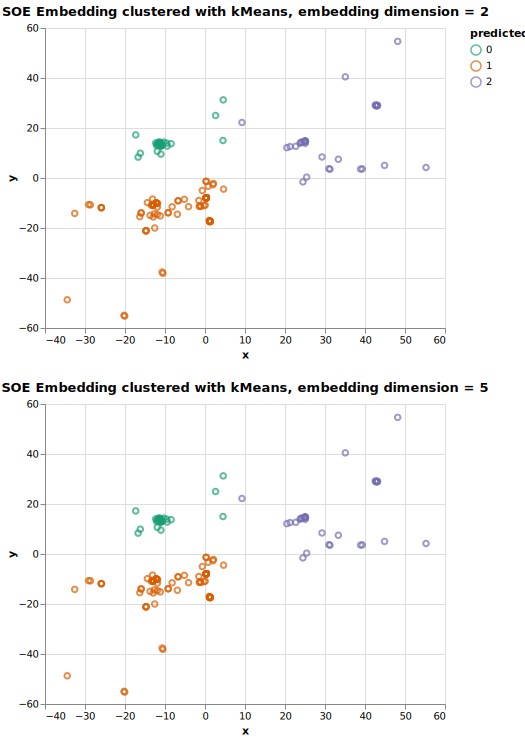

In [15]:
p = AltairPlotter()
p.assignments(embedding_low[:, :2], ypred_soe_kmeans_low).properties(title="SOE Embedding clustered with kMeans, embedding dimension = 2") & p.assignments(embedding_high[:, :2], ypred_soe_kmeans_low).properties(title="SOE Embedding clustered with kMeans, embedding dimension = 5")

We can see that SOE-kMeans doesn't really produce interesting results.

## Conclusion
In this notebook, we have investigated how bipartitions could be interpreted as triplets and thus have opened ourselves up to new and interesting ways of generating triplet data. 

We have then used this knowledge to investigate the Tangles algorithm in some data setups:
- Mindset
- Mindset with useless questions
- SMB with KL cuts
In addition to our widely studied GMM case.

We have compared the performance of the Tangles algorithm to different other clustering algorithms (SOE-kMeans and direct kMeans on the triplets). We have observed that, while Tangles usually performs worse on data from a euclidean space (such as in the GMM model), 
they generally outperform SOE-kMeans on highly non-euclidean spaces with triplets that are highly non-metric (such as in the mindset or graph case). We assume that this is the case because SOE embeds the triplets in a euclidean space before running kMeans on it, which introduces a lot of errors in case of highly non-euclidean data.
Tangles also perform better when a lot of useless cuts are present compared to SOE-kMeans. This is because Tangles can discard the uesless data, while SOE-kMeans tries to conform to all of the triplet constraints.

We have also observed that direct kMeans slightly outperforms (or performs similarly) Tangles on the mindset data, while Tangles outperform direct kMeans on the graph data. Why is the case could still be investigated, also in which graphs this is the case (the performances seem to get more equal the closer p closer is to q).

We have also investigated the more realistic setup of only a few triplets being available. There, performance heavily depends on the method of imputation. Random imputation results in very bad performance for both direct kMeans as well as Tangles, compared to SOE-kMeans. If we impute the triplets with kNN first (with a reasonable k, such as 10 for clusters of size 333), we end up with a performance that is comparable for direct kMeans as well as Tangles, and is significantly better than SOE-kMeans.

### Outlook
Interesting would take the the promising results more robust by averaging them over multiple runs. Interesting cases could be:

- Tangles vs SOE-kMeans on Questionnaire (with/without useless cuts, with/without subsets)
- Tangles vs direct kMeans on Graphs (over multiple p/q)

Also, it would be good to find out a niche where Tangles really dominates over competitor approaches and maybe think more about how kMeans works directly on Triplet data (surprisingly well?).